### Compare structural measures across datasets

#### Datasets
- NIMHANS
- QPN
- PPMI

#### Measures
- Cortical thickness (FS)
- Regional volumes (FS)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting


In [2]:
projects_dir = f"/home/nikhil/projects/Parkinsons/neuro_arch/analysis" 

IDP_dir = f"{projects_dir}/IDP"
figs_dir = f"{projects_dir}/figures/ADPD/poster/"

qpn_release = "Jan_2024"

nimhans_serb_agg_data_dir = f"{IDP_dir}/nimhans_serb/agg_dfs/"
nimhans_metal_agg_data_dir = f"{IDP_dir}/nimhans_metal/agg_dfs/"
nimhans_ylo_agg_data_dir = f"{IDP_dir}/nimhans_ylo/agg_dfs/"

qpn_agg_data_dir = f"{IDP_dir}/qpn/{qpn_release}/agg_dfs/"
ppmi_agg_data_dir = f"{IDP_dir}/ppmi/agg_dfs/"

CT_DKT_csv = "CT_DKT_df.csv"
bilateral_vol_csv = "bilateral_vol_ASEG_df.csv"
global_vol_csv = "global_vol_ASEG_df.csv"

demo_cols = ["participant_id","bids_id","age","sex","group","hemi","ds"]

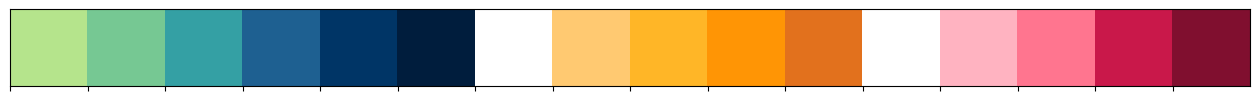

In [3]:
from enum import Enum

# Poster colors
class my_colors(Enum):
    NIM_SERB_CONTROL =  "#B5E48C"
    NIM_SERB_PD =       "#76C893"
    NIM_METAL_CONTROL = "#34A0A4"
    NIM_METAL_PD =      "#1E6091"
    NIM_YLO_CONTROL =   "#003566"
    NIM_YLO_PD =        "#001d3d"

    QPN_CONTROL =       "#ffc971"
    QPN_PD =            "#ffb627"
    QPN_older_CONTROL = "#ff9505"
    QPN_older_PD =      "#e2711d"

    PPMI_CONTROL =      "#FFB3C1"
    PPMI_PD =           "#FF758F"
    PPMI_older_CONTROL= "#C9184A"
    PPMI_older_PD =     "#800F2F"
    

color_list = [  my_colors.NIM_SERB_CONTROL.value, my_colors.NIM_SERB_PD.value,
                my_colors.NIM_METAL_CONTROL.value, my_colors.NIM_METAL_PD.value,
                my_colors.NIM_YLO_CONTROL.value, my_colors.NIM_YLO_PD.value,
                "white",
                my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
                my_colors.QPN_older_CONTROL.value, my_colors.QPN_older_PD.value,
                "white",
                my_colors.PPMI_CONTROL.value, my_colors.PPMI_PD.value,
                my_colors.PPMI_older_CONTROL.value, my_colors.PPMI_older_PD.value              
              ]

palette = sns.color_palette(palette=color_list)

hue_order = ["NIMHANS-1-control", "NIMHANS-1-PD", "NIMHANS-2-control", "NIMHANS-2-PD", 
             "NIMHANS-3-control", "NIMHANS-3-PD", "",
             "QPN-young-control", "QPN-young-PD", "QPN-older-control", "QPN-older-PD", "",
             "PPMI-young-control",  "PPMI-young-PD","PPMI-older-control",  "PPMI-older-PD"] 

sns.palplot(palette)

### Read data

In [4]:
match_age = True
age_thresh = 63

In [5]:
# NIMHANS (SERB + METAL)
nimhans_serb_CT_DKT_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_CT_DKT_df["ds"] = "NIMHANS-1"
n_nimhans_serb_participants = len(nimhans_serb_CT_DKT_df["participant_id"].unique())

nimhans_metal_CT_DKT_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_CT_DKT_df["ds"] = "NIMHANS-2"
n_nimhans_metal_participants = len(nimhans_metal_CT_DKT_df["participant_id"].unique())

nimhans_ylo_CT_DKT_df = pd.read_csv(f"{nimhans_ylo_agg_data_dir}{CT_DKT_csv}") #.drop(columns=["Unnamed: 0"])
nimhans_ylo_CT_DKT_df["ds"] = "NIMHANS-3"
n_nimhans_ylo_participants = len(nimhans_ylo_CT_DKT_df["participant_id"].unique())

# QPN
qpn_CT_DKT_df = pd.read_csv(f"{qpn_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
qpn_CT_DKT_df["ds"] = "QPN"
n_qpn_participants = len(qpn_CT_DKT_df["participant_id"].unique())

# PPMI
ppmi_CT_DKT_df = pd.read_csv(f"{ppmi_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
ppmi_CT_DKT_df["ds"] = "PPMI"
ppmi_CT_DKT_df["participant_id"] = ppmi_CT_DKT_df["participant_id"].astype(str)
ppmi_CT_DKT_df["bids_id"] = "sub-" + ppmi_CT_DKT_df["participant_id"]

n_ppmi_participants = len(ppmi_CT_DKT_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participants (all):{n_qpn_participants}, n_ppmi_participants: {n_ppmi_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")
    qpn_young_CT_DKT_df = qpn_CT_DKT_df[qpn_CT_DKT_df["age"] < age_thresh].copy()
    qpn_young_CT_DKT_df["ds"] = "QPN-young"

    qpn_older_CT_DKT_df = qpn_CT_DKT_df[qpn_CT_DKT_df["age"] >= age_thresh].copy()
    qpn_older_CT_DKT_df["ds"] = "QPN-older"

    ppmi_young_CT_DKT_df = ppmi_CT_DKT_df[ppmi_CT_DKT_df["age"] < age_thresh].copy()
    ppmi_young_CT_DKT_df["ds"] = "PPMI-young"

    ppmi_older_CT_DKT_df = ppmi_CT_DKT_df[ppmi_CT_DKT_df["age"] >= age_thresh].copy()
    ppmi_older_CT_DKT_df["ds"] = "PPMI-older"

    n_qpn_young_participants = len(qpn_young_CT_DKT_df["participant_id"].unique())
    n_qpn_older_participants = len(qpn_older_CT_DKT_df["participant_id"].unique())

    n_ppmi_young_participants = len(ppmi_young_CT_DKT_df["participant_id"].unique())
    n_ppmi_older_participants = len(ppmi_older_CT_DKT_df["participant_id"].unique())

    print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants, n_nimhans_ylo_participants)}")
    print(f"n_qpn_participants (young):{n_qpn_young_participants}, n_ppmi_participants (young): {n_ppmi_young_participants}")
    print(f"n_qpn_participants (older):{n_qpn_older_participants}, n_ppmi_participants: {n_ppmi_older_participants}")

# Concat
CT_DKT_df = pd.concat([nimhans_serb_CT_DKT_df, nimhans_metal_CT_DKT_df, nimhans_ylo_CT_DKT_df,
                        qpn_young_CT_DKT_df, qpn_older_CT_DKT_df,
                        ppmi_young_CT_DKT_df, ppmi_older_CT_DKT_df], axis=0) 


CT_DKT_df["ds_group"] = CT_DKT_df["ds"] + "-" + CT_DKT_df["group"]
CT_DKT_df["ds_hemi"] = CT_DKT_df["ds"] + "\n" + CT_DKT_df["hemi"]
print(f"CT_DKT_df shape: {CT_DKT_df.shape}, n_total_participants: {len(CT_DKT_df['participant_id'].unique())}")


CT_DKT_df.head()

n_nimhans_participants: (86, 130), n_qpn_participants (all):287, n_ppmi_participants: 406
Matching age < 63
n_nimhans_participants: (86, 130, 237)
n_qpn_participants (young):95, n_ppmi_participants (young): 195
n_qpn_participants (older):166, n_ppmi_participants: 210
CT_DKT_df shape: (2238, 44), n_total_participants: 1119


,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,sex,group,hemi,ds,bankssts,frontalpole,temporalpole,MeanThickness,ds_group,ds_hemi
0,2.643,2.648,1.866,3.932,3.098,2.638,2.969,3.294,2.312,2.189,...,M,PD,lh,NIMHANS-1,NaN,NaN,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh
1,3.230,2.844,1.941,3.825,2.900,2.479,3.003,3.427,2.308,2.365,...,M,PD,lh,NIMHANS-1,NaN,NaN,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh
2,2.756,2.717,1.997,3.036,2.709,2.457,2.875,3.183,2.388,2.123,...,M,PD,lh,NIMHANS-1,NaN,NaN,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh
3,2.974,2.603,1.819,3.802,2.701,2.399,2.947,3.205,2.468,2.364,...,NaN,PD,lh,NIMHANS-1,NaN,NaN,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh
4,3.015,2.939,1.998,4.177,3.054,2.831,3.403,3.701,2.462,2.382,...,M,PD,lh,NIMHANS-1,NaN,NaN,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh


### Subsample QPN to match age

In [6]:
CT_DKT_df.groupby(["ds","group","hemi"])["age"].describe()

count       mean        std    min      25%    50%  \
ds         group     hemi                                                       
NIMHANS-1  PD        lh     54.0  55.388889   7.199100  36.00  50.2500  56.00   
                     rh     54.0  55.388889   7.199100  36.00  50.2500  56.00   
           control   lh     15.0  52.000000   6.011893  41.00  49.0000  53.00   
                     rh     15.0  52.000000   6.011893  41.00  49.0000  53.00   
NIMHANS-2  PD        lh     59.0  53.644068  10.133187  24.00  46.0000  55.00   
                     rh     59.0  53.644068  10.133187  24.00  46.0000  55.00   
           control   lh     64.0  50.015625  10.418988  20.00  42.7500  50.00   
                     rh     64.0  50.015625  10.418988  20.00  42.7500  50.00   
NIMHANS-3  PD        lh    198.0  54.075758  10.983574  23.00  47.2500  55.00   
                     rh    198.0  54.075758  10.983574  23.00  47.2500  55.00   
           control   lh     37.0  44.148649  11.493274  25.00  35.0000  46.00   
                     rh     37.0  44.148649  11.493274  25.00  35.0000  46.00   
PPMI-older PD        lh    124.0  69.516129   4.591409  63.00  65.0000  69.00   
                     rh    124.0  69.516129   4.591409  63.00  65.0000  69.00   
           control   lh     37.0  68.972973   5.041420  63.00  65.0000  68.00   
                     rh     37.0  68.972973   5.041420  63.00  65.0000  68.00   
           prodromal lh     49.0  68.877551   5.105686  63.00  65.0000  68.00   
                     rh     49.0  68.877551   5.105686  63.00  65.0000  68.00   
PPMI-young PD        lh    105.0  54.247619   5.705566  38.00  50.0000  55.00   
                     rh    105.0  54.247619   5.705566  38.00  50.0000  55.00   
           control   lh     42.0  51.642857   7.938242  31.00  46.2500  53.50   
                     rh     42.0  51.642857   7.938242  31.00  46.2500  53.50   
           prodromal lh     48.0  56.187500   4.451422  42.00  53.7500  57.00   
                     rh     48.0  56.187500   4.451422  42.00  53.7500  57.00   
QPN-older  PD        lh    131.0  70.829695   5.541496  63.23  65.9750  69.54   
                     rh    131.0  70.829695   5.541496  63.23  65.9750  69.54   
           control   lh     35.0  70.032571   4.917366  63.14  66.9350  68.56   
                     rh     35.0  70.032571   4.917366  63.14  66.9350  68.56   
QPN-young  PD        lh     68.0  55.809559   4.971906  40.83  53.0375  56.33   
                     rh     68.0  55.809559   4.971906  40.83  53.0375  56.33   
           control   lh     27.0  51.308519   9.071232  25.98  45.8050  53.64   
                     rh     27.0  51.308519   9.071232  25.98  45.8050  53.64   

                              75%    max  
ds         group     hemi                 
NIMHANS-1  PD        lh    61.000  67.00  
                     rh    61.000  67.00  
           control   lh    56.500  60.00  
                     rh    56.500  60.00  
NIMHANS-2  PD        lh    61.000  72.00  
                     rh    61.000  72.00  
           control   lh    57.250  73.00  
                     rh    57.250  73.00  
NIMHANS-3  PD        lh    62.000  78.00  
                     rh    62.000  78.00  
           control   lh    52.000  65.00  
                     rh    52.000  65.00  
PPMI-older PD        lh    73.000  82.00  
                     rh    73.000  82.00  
           control   lh    72.000  81.00  
                     rh    72.000  81.00  
           prodromal lh    72.000  84.00  
                     rh    72.000  84.00  
PPMI-young PD        lh    59.000  62.00  
                     rh    59.000  62.00  
           control   lh    57.750  62.00  
                     rh    57.750  62.00  
           prodromal lh    60.000  62.00  
                     rh    60.000  62.00  
QPN-older  PD        lh    74.580  88.34  
                     rh    74.580  88.34  
           control   lh    71.640  82.84  
                     rh  

/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


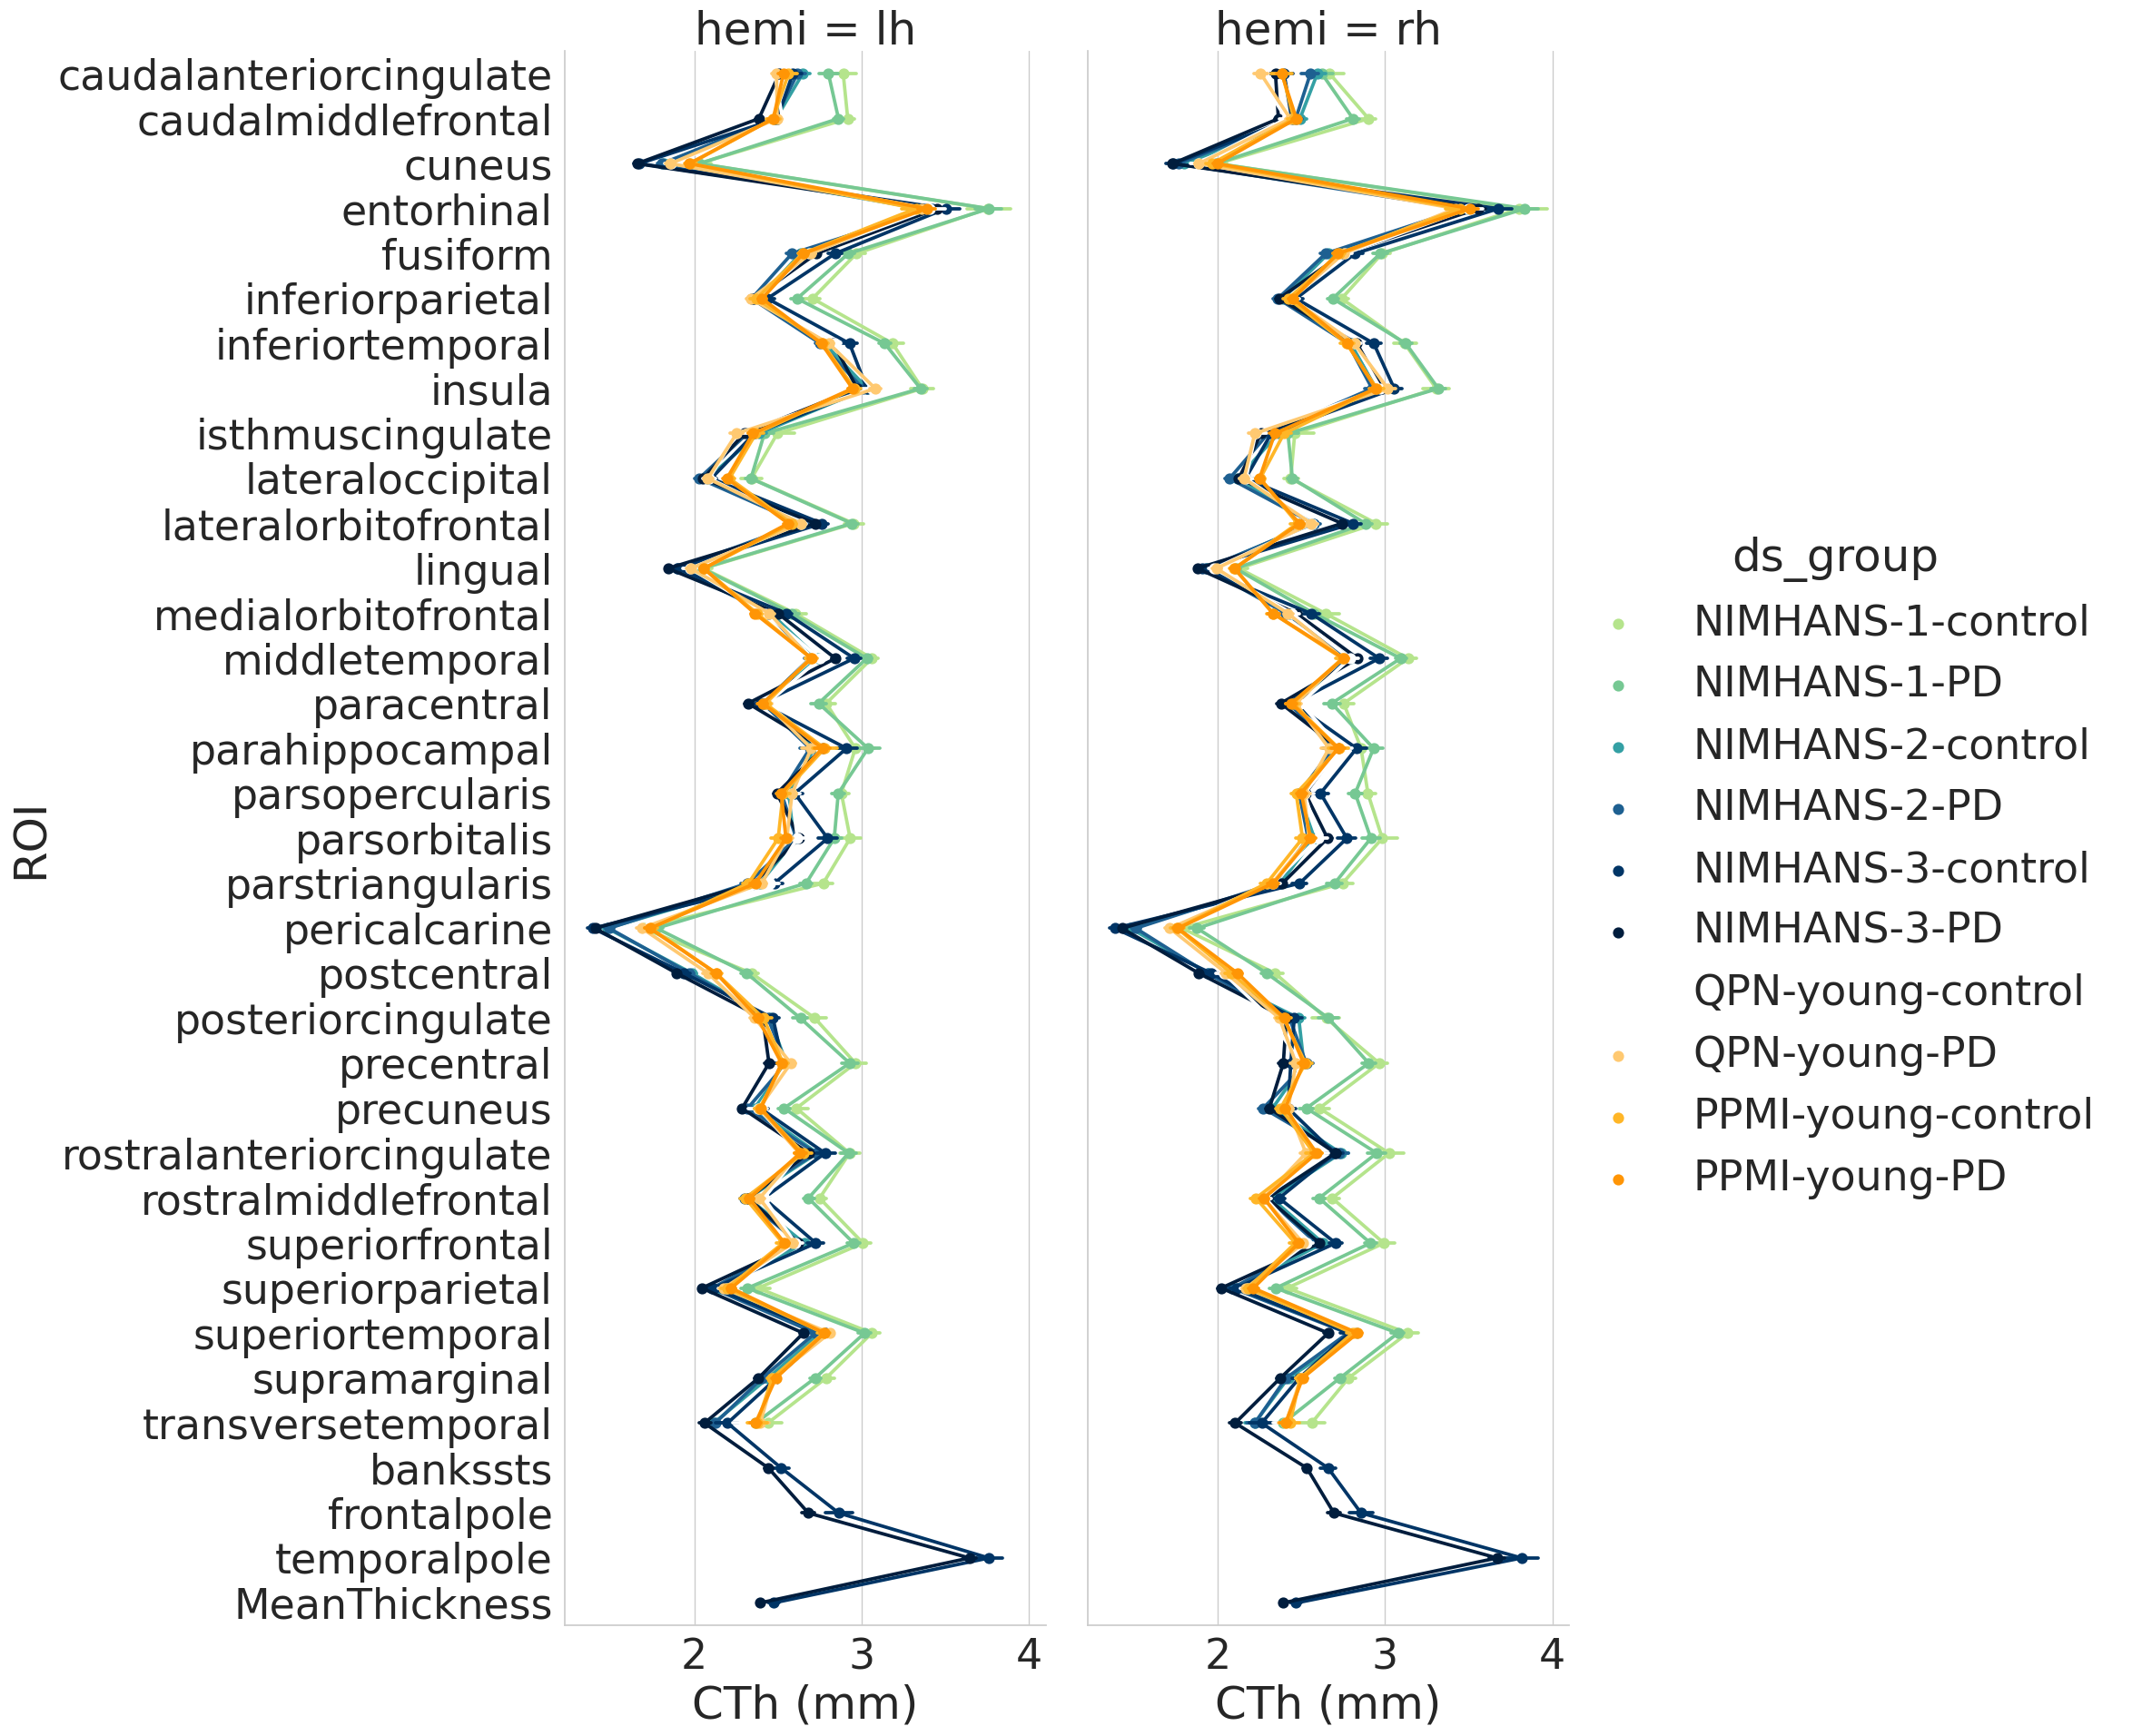

In [7]:
save_fig = True

# CT_DKT_df = CT_DKT_df[CT_DKT_df["dataset"].isin(["PPMI", "QPN", "NIMHANS_SERB"])]
CT_DKT_df = CT_DKT_df[CT_DKT_df["group"].isin(["control", "PD"])]

hue_order = ["NIMHANS-1-control", "NIMHANS-1-PD", "NIMHANS-2-control", "NIMHANS-2-PD", "NIMHANS-3-control", "NIMHANS-3-PD",
             "QPN-young-control", "QPN-young-PD", 
             "PPMI-young-control",  "PPMI-young-PD"]

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["ds_group","ds_hemi"],
    var_name="ROI", 
    value_name="CTh (mm)")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set_theme(font_scale=3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CTh (mm)", hue="ds_group", col="hemi",kind="point",palette=palette, hue_order=hue_order, legend=True,
                    data=plot_df, aspect=0.5, height=20)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT_point.png")

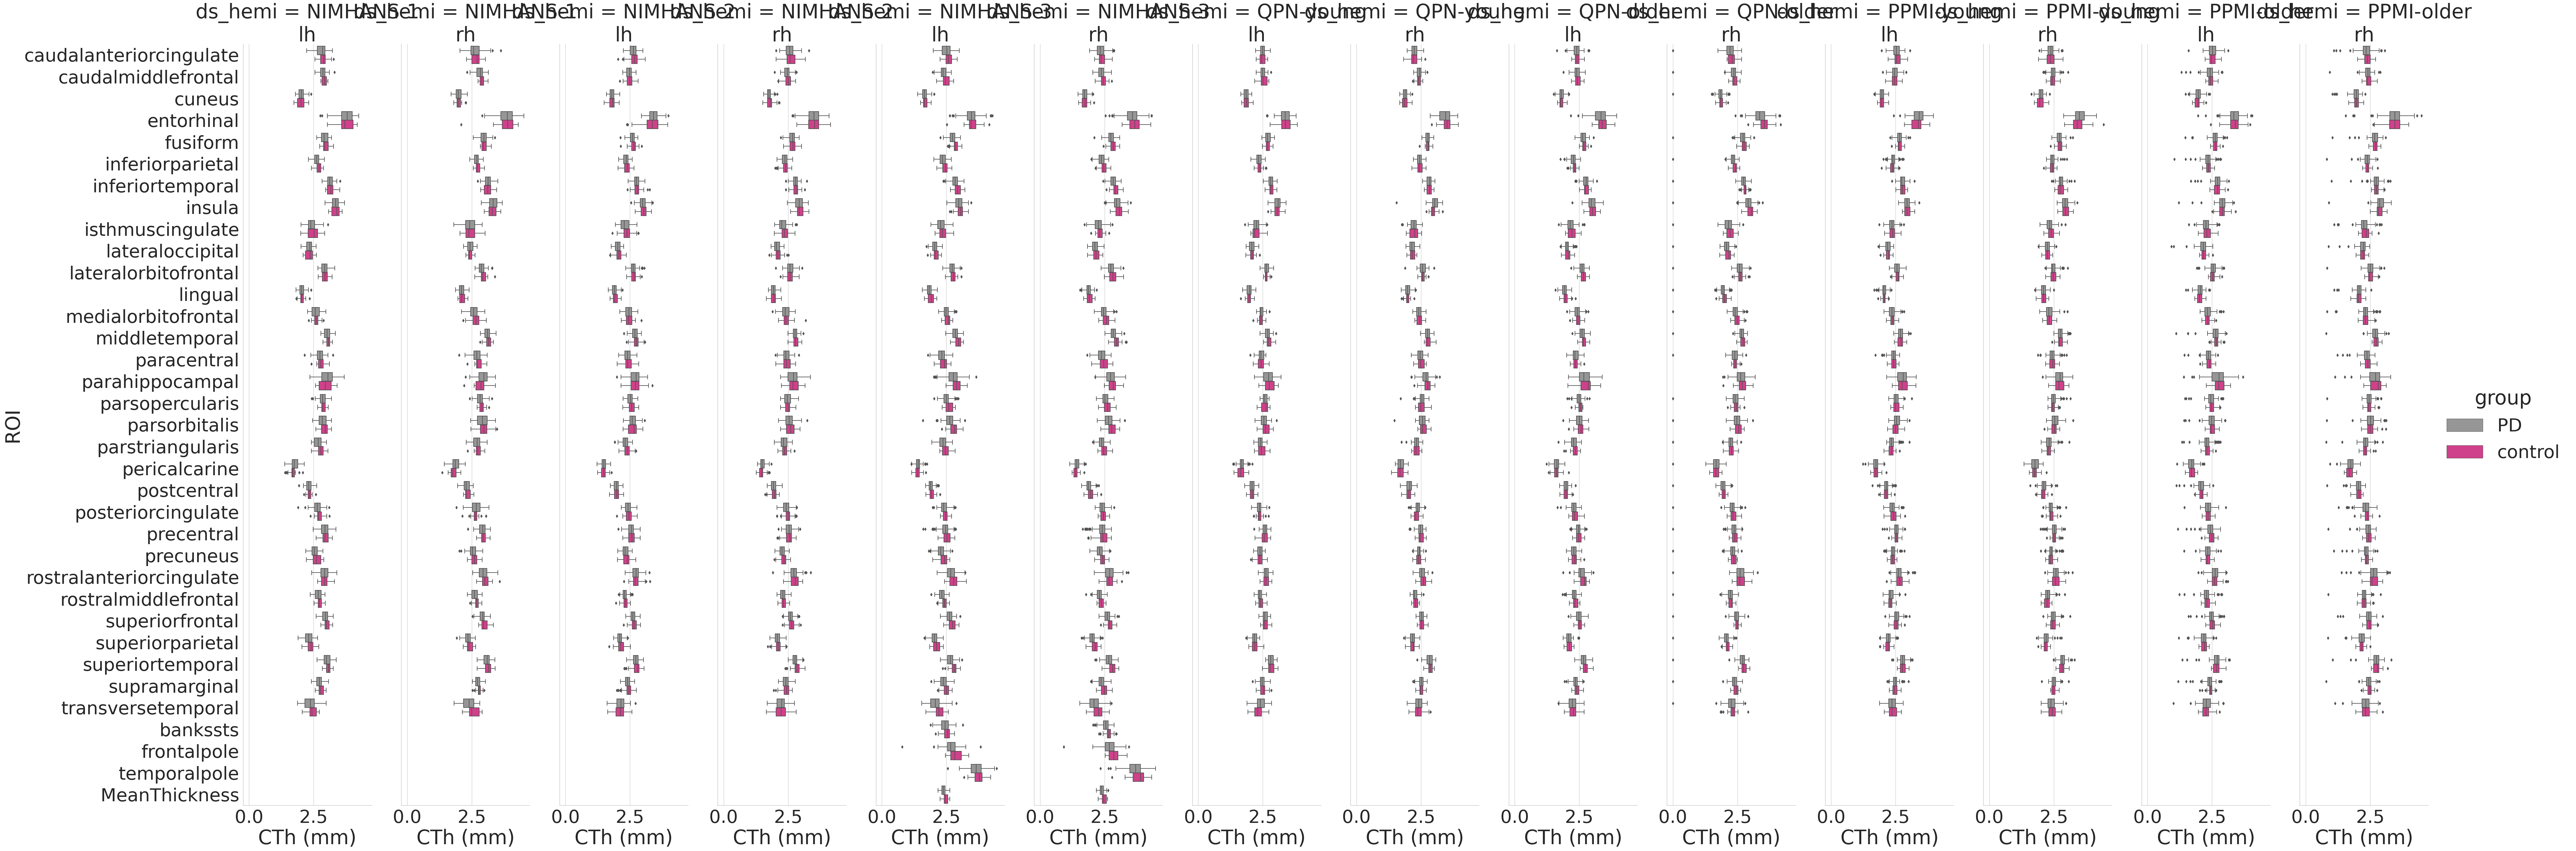

In [8]:
save_fig = False

# CT_DKT_df = CT_DKT_df[CT_DKT_df["dataset"].isin(["PPMI", "QPN", "NIMHANS_SERB"])]
CT_DKT_df = CT_DKT_df[CT_DKT_df["group"].isin(["control", "PD"])]

color_list = [  "#969696", "#e7298a" ]

palette_group = sns.color_palette(palette=color_list)

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["ds_group","ds_hemi"],
    var_name="ROI", 
    value_name="CTh (mm)")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)



sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CTh (mm)", hue="group", col="ds_hemi", kind="box",palette=palette_group, legend=True,
                    data=plot_df, aspect=0.2, height=30)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

In [9]:
CT_DKT_df.iloc[:,:31].min(axis=0)

caudalanteriorcingulate     1.090
caudalmiddlefrontal         0.931
cuneus                      1.029
entorhinal                  1.554
fusiform                    1.031
inferiorparietal            0.817
inferiortemporal            1.000
insula                      0.899
isthmuscingulate            1.107
lateraloccipital            0.880
lateralorbitofrontal        0.830
lingual                     1.104
medialorbitofrontal         0.827
middletemporal              0.791
paracentral                 1.231
parahippocampal             1.132
parsopercularis             0.823
parsorbitalis               0.814
parstriangularis            0.787
pericalcarine               0.938
postcentral                 0.829
posteriorcingulate          1.272
precentral                  0.871
precuneus                   1.088
rostralanteriorcingulate    1.390
rostralmiddlefrontal        0.876
superiorfrontal             1.242
superiorparietal            0.860
superiortemporal            1.047
supramarginal 

### Aseg bilateral volume

In [9]:
FS_version_name_map = {"Thalamus": "Thalamus-Proper"}

In [10]:
# NIMHANS (SERB + METAL)
nimhans_serb_hemi_ASEG_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_hemi_ASEG_df["ds"] = "NIMHANS-1"
n_nimhans_serb_participants = len(nimhans_serb_hemi_ASEG_df["participant_id"].unique())

nimhans_metal_hemi_ASEG_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_hemi_ASEG_df["ds"] = "NIMHANS-2"
n_nimhans_metal_participants = len(nimhans_metal_hemi_ASEG_df["participant_id"].unique())

nimhans_ylo_hemi_ASEG_df = pd.read_csv(f"{nimhans_ylo_agg_data_dir}{bilateral_vol_csv}") #.drop(columns=["Unnamed: 0"])
nimhans_ylo_hemi_ASEG_df["ds"] = "NIMHANS-3"
n_nimhans_ylo_participants = len(nimhans_ylo_hemi_ASEG_df["participant_id"].unique())
# Rename columns (FS7.1) # Need to update this for other datasets
nimhans_ylo_hemi_ASEG_df = nimhans_ylo_hemi_ASEG_df.rename(columns=FS_version_name_map)

# QPN
qpn_hemi_ASEG_df = pd.read_csv(f"{qpn_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
qpn_hemi_ASEG_df["ds"] = "QPN"
n_qpn_participants = len(qpn_hemi_ASEG_df["participant_id"].unique())

# PPMI
ppmi_hemi_ASEG_df = pd.read_csv(f"{ppmi_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
ppmi_hemi_ASEG_df["ds"] = "PPMI"
n_ppmi_participants = len(ppmi_hemi_ASEG_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants,n_nimhans_metal_participants, n_nimhans_ylo_participants)}, n_qpn_participants:{n_qpn_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")

    ppmi_younger_hemi_ASEG_df = ppmi_hemi_ASEG_df[ppmi_hemi_ASEG_df["age"] < age_thresh].copy()
    ppmi_younger_hemi_ASEG_df["ds"] = "PPMI-young"
    n_younger_ppmi_participants = len(ppmi_younger_hemi_ASEG_df["participant_id"].unique())

    ppmi_older_hemi_ASEG_df = ppmi_hemi_ASEG_df[ppmi_hemi_ASEG_df["age"] >= age_thresh].copy()
    ppmi_older_hemi_ASEG_df["ds"] = "PPMI-older"
    n_older_ppmi_participants = len(ppmi_older_hemi_ASEG_df["participant_id"].unique())

    qpn_younger_hemi_ASEG_df = qpn_hemi_ASEG_df[qpn_hemi_ASEG_df["age"] < age_thresh].copy()
    qpn_younger_hemi_ASEG_df["ds"] = "QPN-young"
    n_qpn_younger_participants = len(qpn_younger_hemi_ASEG_df["participant_id"].unique())

    qpn_older_hemi_ASEG_df = qpn_hemi_ASEG_df[qpn_hemi_ASEG_df["age"] >= age_thresh].copy()
    qpn_older_hemi_ASEG_df["ds"] = "QPN-older"
    n_qpn_older_participants = len(qpn_older_hemi_ASEG_df["participant_id"].unique())

    print(f"n_nimhans_participants: {(n_nimhans_serb_participants,n_nimhans_metal_participants, n_nimhans_ylo_participants)}")
    print(f"n_qpn_younger_participants:{n_qpn_younger_participants}, n_qpn_older_participants: {n_qpn_older_participants}")
    print(f"n_ppmi_younger_participants:{n_younger_ppmi_participants}, n_ppmi_older_participants: {n_older_ppmi_participants}")

# Concat
hemi_ASEG_df = pd.concat([nimhans_serb_hemi_ASEG_df, nimhans_metal_hemi_ASEG_df, nimhans_ylo_hemi_ASEG_df,
                          qpn_younger_hemi_ASEG_df, qpn_older_hemi_ASEG_df,
                          ppmi_younger_hemi_ASEG_df, ppmi_older_hemi_ASEG_df], axis=0)
hemi_ASEG_df["ds_group"] = hemi_ASEG_df["ds"] + "-" + hemi_ASEG_df["group"]
hemi_ASEG_df["ds_hemi"] = hemi_ASEG_df["ds"] + "\n" + hemi_ASEG_df["hemi"]
print(f"hemi_ASEG_df shape: {hemi_ASEG_df.shape}")

hemi_ASEG_df = hemi_ASEG_df[hemi_ASEG_df["group"]!="prodromal"].copy()

## Remove outliers
## This is structure specific (need to be QCed visually)
hemi_roi_list = ['Pallidum', 'Thalamus-Proper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                 'Lateral-Ventricle']
min_vol_thresh_list = [1000,5000,2000,750,1500,2000,200,1000]
max_vol_thresh_list = [3000,10000,7000,2500,5500,6000,1000,60000]
outlier_min_thesh_dict = dict(zip(hemi_roi_list, min_vol_thresh_list))
outlier_max_thesh_dict = dict(zip(hemi_roi_list, max_vol_thresh_list))

remove_outliers = True
if remove_outliers:
    print("Removing outliers")
    for roi, thresh in outlier_min_thesh_dict.items():
        n_participants = hemi_ASEG_df["bids_id"].nunique()
        print(f"roi: {roi}, n_participants: {n_participants}")
        hemi_ASEG_df = hemi_ASEG_df[hemi_ASEG_df[roi] > thresh].copy()
        n_participants = hemi_ASEG_df["bids_id"].nunique()
        print(f"n_participants after outlier removal: {n_participants}")

    for roi, thresh in outlier_max_thesh_dict.items():
        n_participants = hemi_ASEG_df["bids_id"].nunique()
        print(f"roi: {roi}, n_participants: {n_participants}")
        hemi_ASEG_df = hemi_ASEG_df[hemi_ASEG_df[roi] < thresh].copy()
        n_participants = hemi_ASEG_df["bids_id"].nunique()
        print(f"n_participants after outlier removal: {n_participants}")


hemi_ASEG_df.head()

n_nimhans_participants: (86, 130, 237), n_qpn_participants:287
Matching age < 63
n_nimhans_participants: (86, 130, 237)
n_qpn_younger_participants:95, n_qpn_older_participants: 166
n_ppmi_younger_participants:195, n_ppmi_older_participants: 210
hemi_ASEG_df shape: (2238, 27)
Removing outliers
roi: Pallidum, n_participants: 453
n_participants after outlier removal: 453
roi: Thalamus-Proper, n_participants: 453
n_participants after outlier removal: 450
roi: Putamen, n_participants: 450
n_participants after outlier removal: 450
roi: Amygdala, n_participants: 450
n_participants after outlier removal: 450
roi: Caudate, n_participants: 450
n_participants after outlier removal: 450
roi: Hippocampus, n_participants: 450
n_participants after outlier removal: 450
roi: Accumbens-area, n_participants: 450
n_participants after outlier removal: 449
roi: Lateral-Ventricle, n_participants: 449
n_participants after outlier removal: 449
roi: Pallidum, n_participants: 449
n_participants after outlier rem

,Cerebellum-White-Matter,Amygdala,Lateral-Ventricle,Cerebellum-Cortex,Putamen,Thalamus-Proper,vessel,choroid-plexus,Caudate,Hippocampus,...,sex,group,hemi,ds,WM-hypointensities,non-WM-hypointensities,CerebralWhiteMatter,Cortex,ds_group,ds_hemi
0,14102.900391,1659.300049,9170.500000,49608.800781,4586.500000,6357.399902,125.800003,684.400024,3355.899902,3580.399902,...,M,PD,lh,NIMHANS-1,NaN,NaN,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh
2,20009.800781,1357.099976,16945.599609,50561.199219,4779.700195,6195.899902,29.299999,1066.400024,3021.699951,3541.500000,...,M,PD,lh,NIMHANS-1,NaN,NaN,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh
3,10348.900391,1344.599976,10064.700195,41859.898438,2910.699951,5412.100098,13.900000,818.299988,1672.599976,3827.000000,...,NaN,PD,lh,NIMHANS-1,NaN,NaN,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh
4,11251.599609,1442.900024,8531.599609,46157.500000,3410.100098,5824.899902,40.000000,592.799988,2352.199951,3377.800049,...,M,PD,lh,NIMHANS-1,NaN,NaN,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh
5,13945.700195,1570.699951,5322.200195,41812.800781,5053.700195,6990.500000,43.400002,490.700012,2814.300049,3485.300049,...,M,PD,lh,NIMHANS-1,NaN,NaN,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh


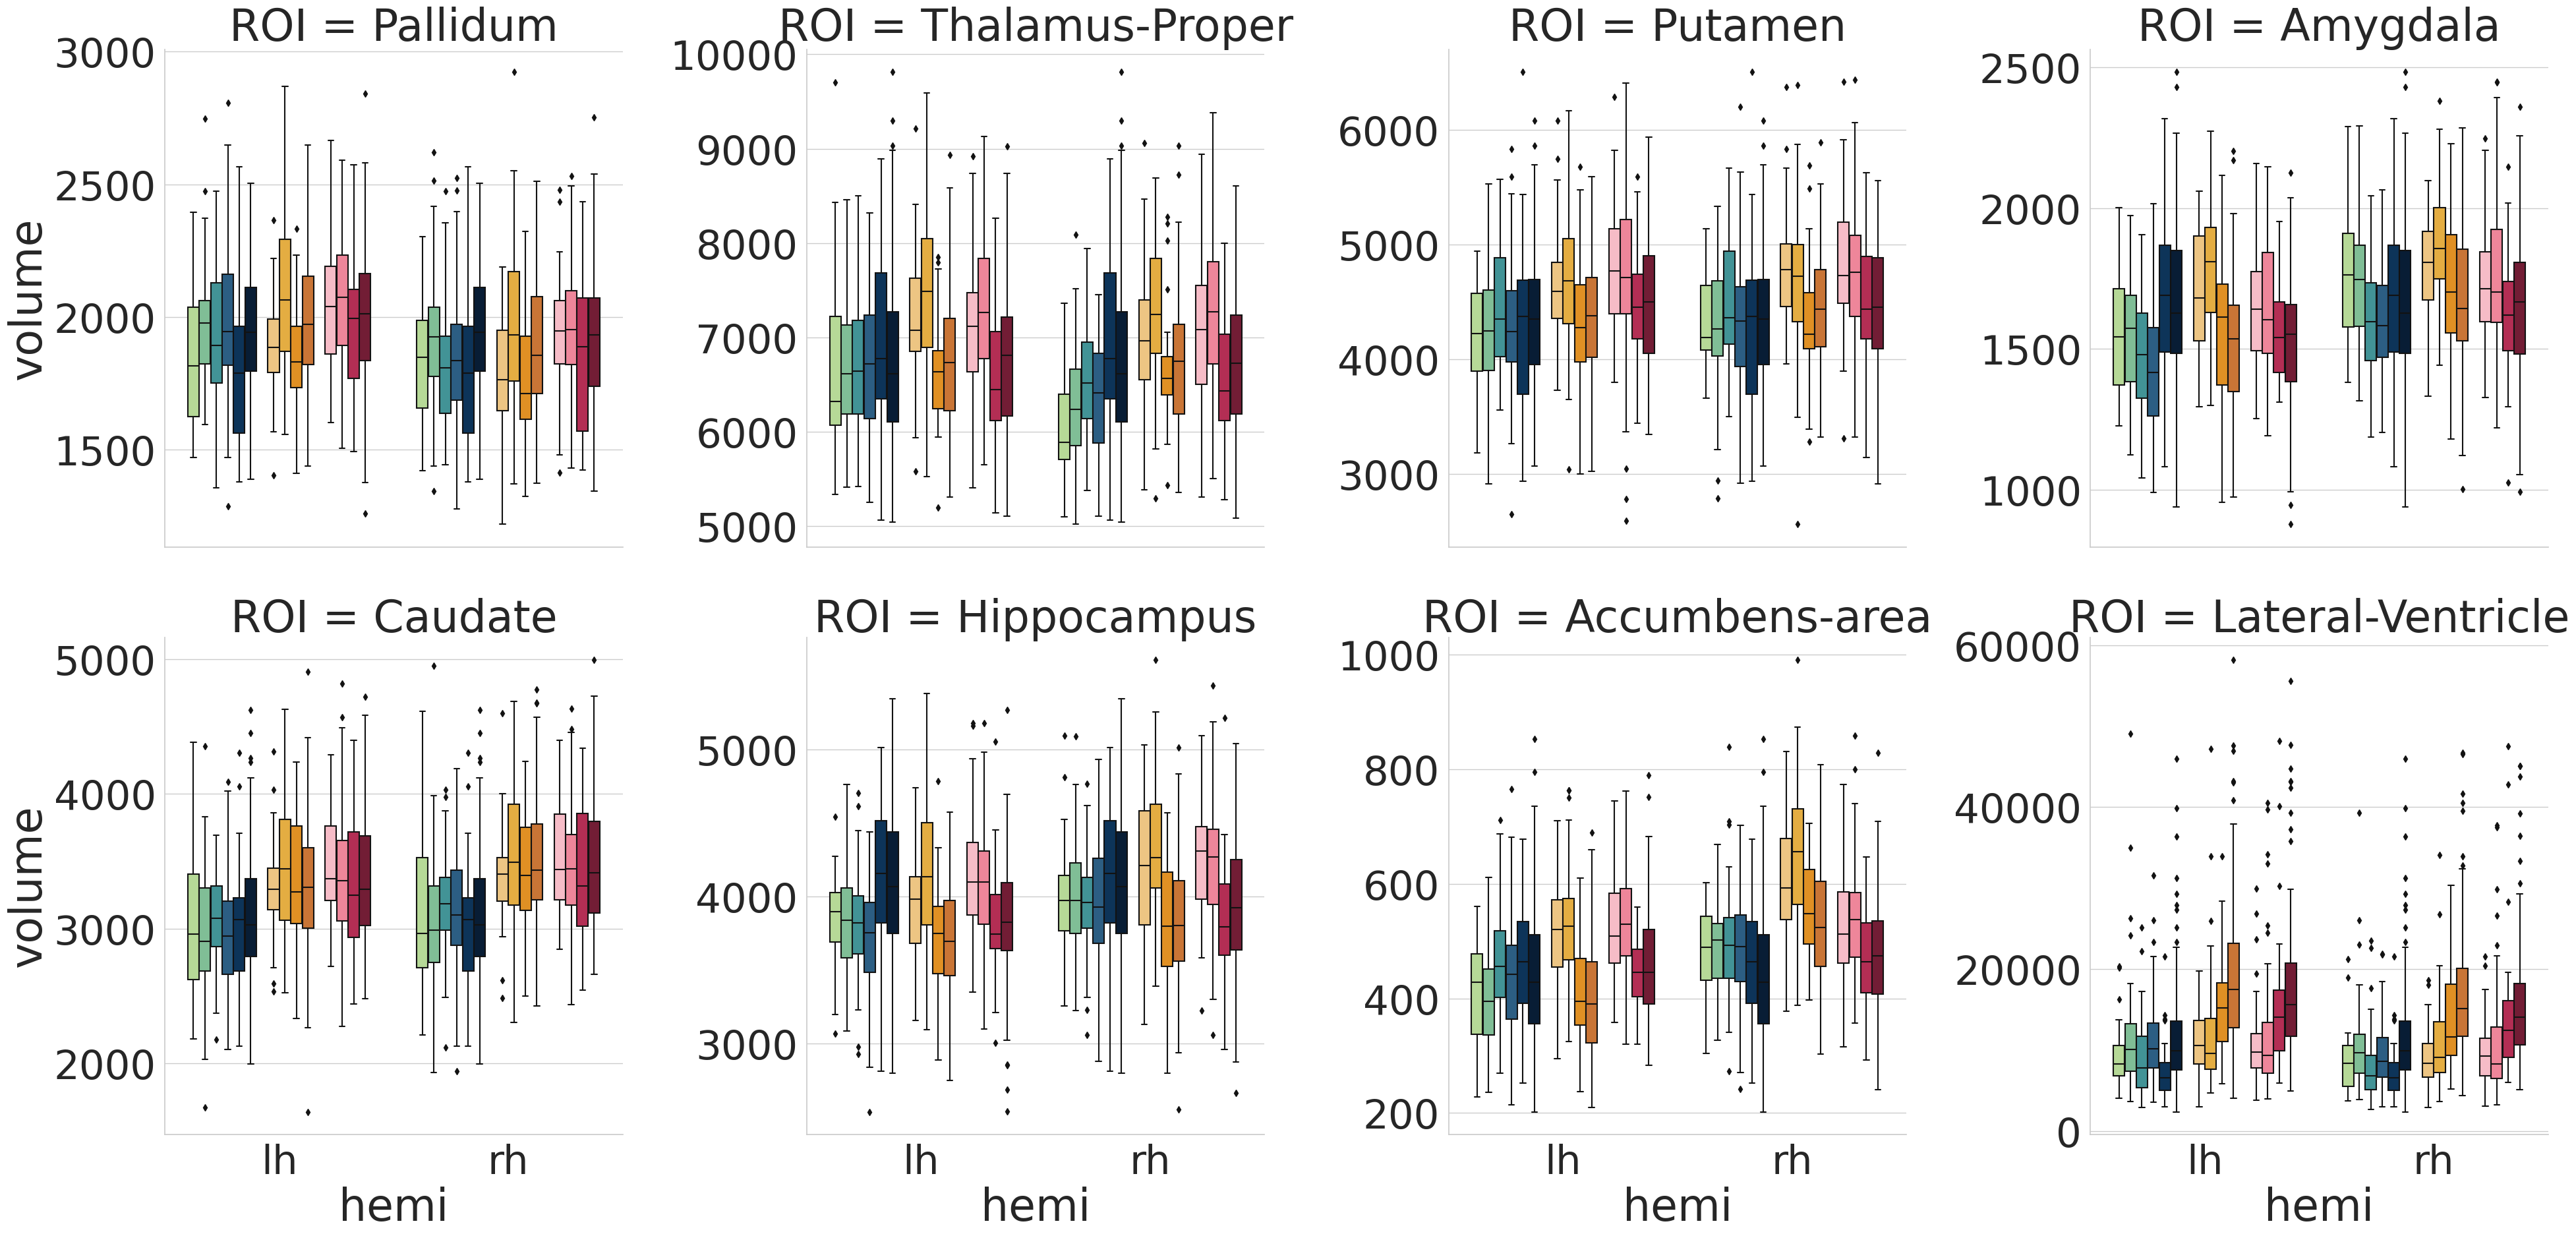

In [11]:
save_fig = True

# hemi_ASEG_df = hemi_ASEG_df[hemi_ASEG_df["dataset"].isin(["PPMI", "QPN", "NIMHANS_SERB"])]
hemi_ASEG_df = hemi_ASEG_df[hemi_ASEG_df["group"].isin(["control", "PD"])]

vol_ASEG_df_melt = hemi_ASEG_df.melt(
    id_vars=demo_cols + ["ds_group","ds_hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df = plot_df.drop(columns=["participant_id"])

plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus-Proper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                 'Lateral-Ventricle']
#'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC','Inf-Lat-Vent'

color_list = [  my_colors.NIM_SERB_CONTROL.value, my_colors.NIM_SERB_PD.value,
                my_colors.NIM_METAL_CONTROL.value, my_colors.NIM_METAL_PD.value,
                my_colors.NIM_YLO_CONTROL.value, my_colors.NIM_YLO_PD.value,
                "white",
                my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
                my_colors.QPN_older_CONTROL.value, my_colors.QPN_older_PD.value,
                "white",
                my_colors.PPMI_CONTROL.value, my_colors.PPMI_PD.value,
                my_colors.PPMI_older_CONTROL.value, my_colors.PPMI_older_PD.value              
              ]

palette = sns.color_palette(palette=color_list)

hue_order = ["NIMHANS-1-control", "NIMHANS-1-PD", "NIMHANS-2-control", "NIMHANS-2-PD", 
             "NIMHANS-3-control", "NIMHANS-3-PD", "",
             "QPN-young-control", "QPN-young-PD", "QPN-older-control", "QPN-older-PD", "",
             "PPMI-young-control",  "PPMI-young-PD","PPMI-older-control",  "PPMI-older-PD"] 

sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI",kind="box", col_wrap=4, col_order=hemi_roi_list, 
                    hue_order=hue_order, palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_hemi.png")

### Global volumes

In [12]:
FS_version_name_map = {
    "SupraTentorialVol": "SupraTentorial",
    "TotalGrayVol": "TotalGray",
    "SubCortGrayVol": "SubCortGray",
    "EstimatedTotalIntraCranialVol": "EstimatedTotalIntraCranial",
}

In [13]:
# NIMHANS (SERB + METAL)
nimhans_serb_global_ASEG_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_global_ASEG_df["ds"] = "NIMHANS-1"
n_nimhans_serb_participants = len(nimhans_serb_global_ASEG_df["participant_id"].unique())

nimhans_metal_global_ASEG_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_global_ASEG_df["ds"] = "NIMHANS-2"
n_nimhans_metal_participants = len(nimhans_metal_global_ASEG_df["participant_id"].unique())

nimhans_ylo_global_ASEG_df = pd.read_csv(f"{nimhans_ylo_agg_data_dir}{global_vol_csv}") #.drop(columns=["Unnamed: 0"])
nimhans_ylo_global_ASEG_df["ds"] = "NIMHANS-3"
n_nimhans_ylo_participants = len(nimhans_ylo_global_ASEG_df["participant_id"].unique())
# rename cols
# TODO need to update this for other datasets
nimhans_ylo_global_ASEG_df = nimhans_ylo_global_ASEG_df.rename(columns=FS_version_name_map)



# QPN
qpn_global_ASEG_df = pd.read_csv(f"{qpn_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
## Reanme eTIV col
qpn_global_ASEG_df = qpn_global_ASEG_df.rename(columns={"EstimatedTotalIntraCranialVol":"EstimatedTotalIntraCranial"})
qpn_global_ASEG_df["ds"] = "QPN"
n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())

# PPMI
ppmi_global_ASEG_df = pd.read_csv(f"{ppmi_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
ppmi_global_ASEG_df["ds"] = "PPMI"
n_ppmi_participants = len(ppmi_global_ASEG_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participants:{n_qpn_participants}")


if match_age:
    print(f"Matching age < {age_thresh}")

    ppmi_younger_global_ASEG_df = ppmi_global_ASEG_df[ppmi_global_ASEG_df["age"] < age_thresh].copy()
    ppmi_younger_global_ASEG_df["ds"] = "PPMI-young"
    n_younger_ppmi_participants = len(ppmi_younger_global_ASEG_df["participant_id"].unique())

    ppmi_older_global_ASEG_df = ppmi_global_ASEG_df[ppmi_global_ASEG_df["age"] >= age_thresh].copy()
    ppmi_older_global_ASEG_df["ds"] = "PPMI-older"
    n_older_ppmi_participants = len(ppmi_older_global_ASEG_df["participant_id"].unique())

    qpn_younger_global_ASEG_df = qpn_global_ASEG_df[qpn_global_ASEG_df["age"] < age_thresh].copy()
    qpn_younger_global_ASEG_df["ds"] = "QPN-young"
    n_qpn_younger_participants = len(qpn_younger_global_ASEG_df["participant_id"].unique())

    qpn_older_global_ASEG_df = qpn_global_ASEG_df[qpn_global_ASEG_df["age"] >= age_thresh].copy()
    qpn_older_global_ASEG_df["ds"] = "QPN-older"
    n_qpn_older_participants = len(qpn_older_global_ASEG_df["participant_id"].unique())

    print(f"n_nimhans_participants: {(n_nimhans_serb_participants,n_nimhans_metal_participants, n_nimhans_ylo_participants)}")
    print(f"n_qpn_younger_participants:{n_qpn_younger_participants}, n_qpn_older_participants: {n_qpn_older_participants}")
    print(f"n_ppmi_younger_participants:{n_younger_ppmi_participants}, n_ppmi_older_participants: {n_older_ppmi_participants}")

# Concat
global_vol_ASEG_df = pd.concat([nimhans_serb_global_ASEG_df, nimhans_metal_global_ASEG_df, nimhans_ylo_global_ASEG_df,
                          qpn_younger_global_ASEG_df, qpn_older_global_ASEG_df,
                          ppmi_younger_global_ASEG_df, ppmi_older_global_ASEG_df], axis=0)

global_vol_ASEG_df["ds_group"] = global_vol_ASEG_df["ds"] + "-" + global_vol_ASEG_df["group"]

global_vol_ASEG_df = global_vol_ASEG_df[global_vol_ASEG_df["group"]!="prodromal"] .copy()

print(f"global_vol_ASEG_df shape: {global_vol_ASEG_df.shape}")

## tmp
# qpn_global_ASEG_df = qpn_global_ASEG_df.drop(columns=["participant_id"])

qpn_global_ASEG_df.head()

n_nimhans_participants: (86, 130), n_qpn_participants:287
Matching age < 63
n_nimhans_participants: (86, 130, 237)
n_qpn_younger_participants:95, n_qpn_older_participants: 166
n_ppmi_younger_participants:195, n_ppmi_older_participants: 210
global_vol_ASEG_df shape: (1022, 46)


,3rd-Ventricle,4th-Ventricle,5th-Ventricle,Brain-Stem,BrainSeg,BrainSegNotVent,BrainSegNotVent.1,CC_Anterior,CC_Central,CC_Mid_Anterior,...,TotalGray,VentricleChoroidVol,WM-hypointensities,non-WM-hypointensities,participant_id,age,sex,group,hemi,ds
0,1360.3,1787.4,0.0,25180.7,1268014.0,1241132.0,1241132.0,1322.0,531.8,648.6,...,640926.078926,22462.0,840.9,0.0,MNI0028,60.19,M,PD,global,QPN
1,2976.9,2691.0,0.0,20471.7,1250678.0,1160664.0,1160664.0,1011.1,445.4,491.8,...,619693.412514,82652.0,6680.3,0.0,MNI0056,79.24,M,PD,global,QPN
2,1429.2,988.4,0.0,27453.5,1250635.0,1233803.0,1233803.0,768.3,756.6,578.4,...,647481.631716,13498.0,7384.4,0.0,MNI0058,57.43,M,PD,global,QPN
3,1348.8,1599.4,0.0,20654.2,1063409.0,1037897.0,1037897.0,854.4,420.8,705.6,...,581838.746237,21777.0,2428.0,0.0,MNI0068,69.30,M,PD,global,QPN
4,952.4,1449.5,0.0,21743.1,1144991.0,1131912.0,1131912.0,930.8,801.1,797.4,...,626431.995060,9824.0,656.9,0.0,MNI0079,50.08,F,PD,global,QPN


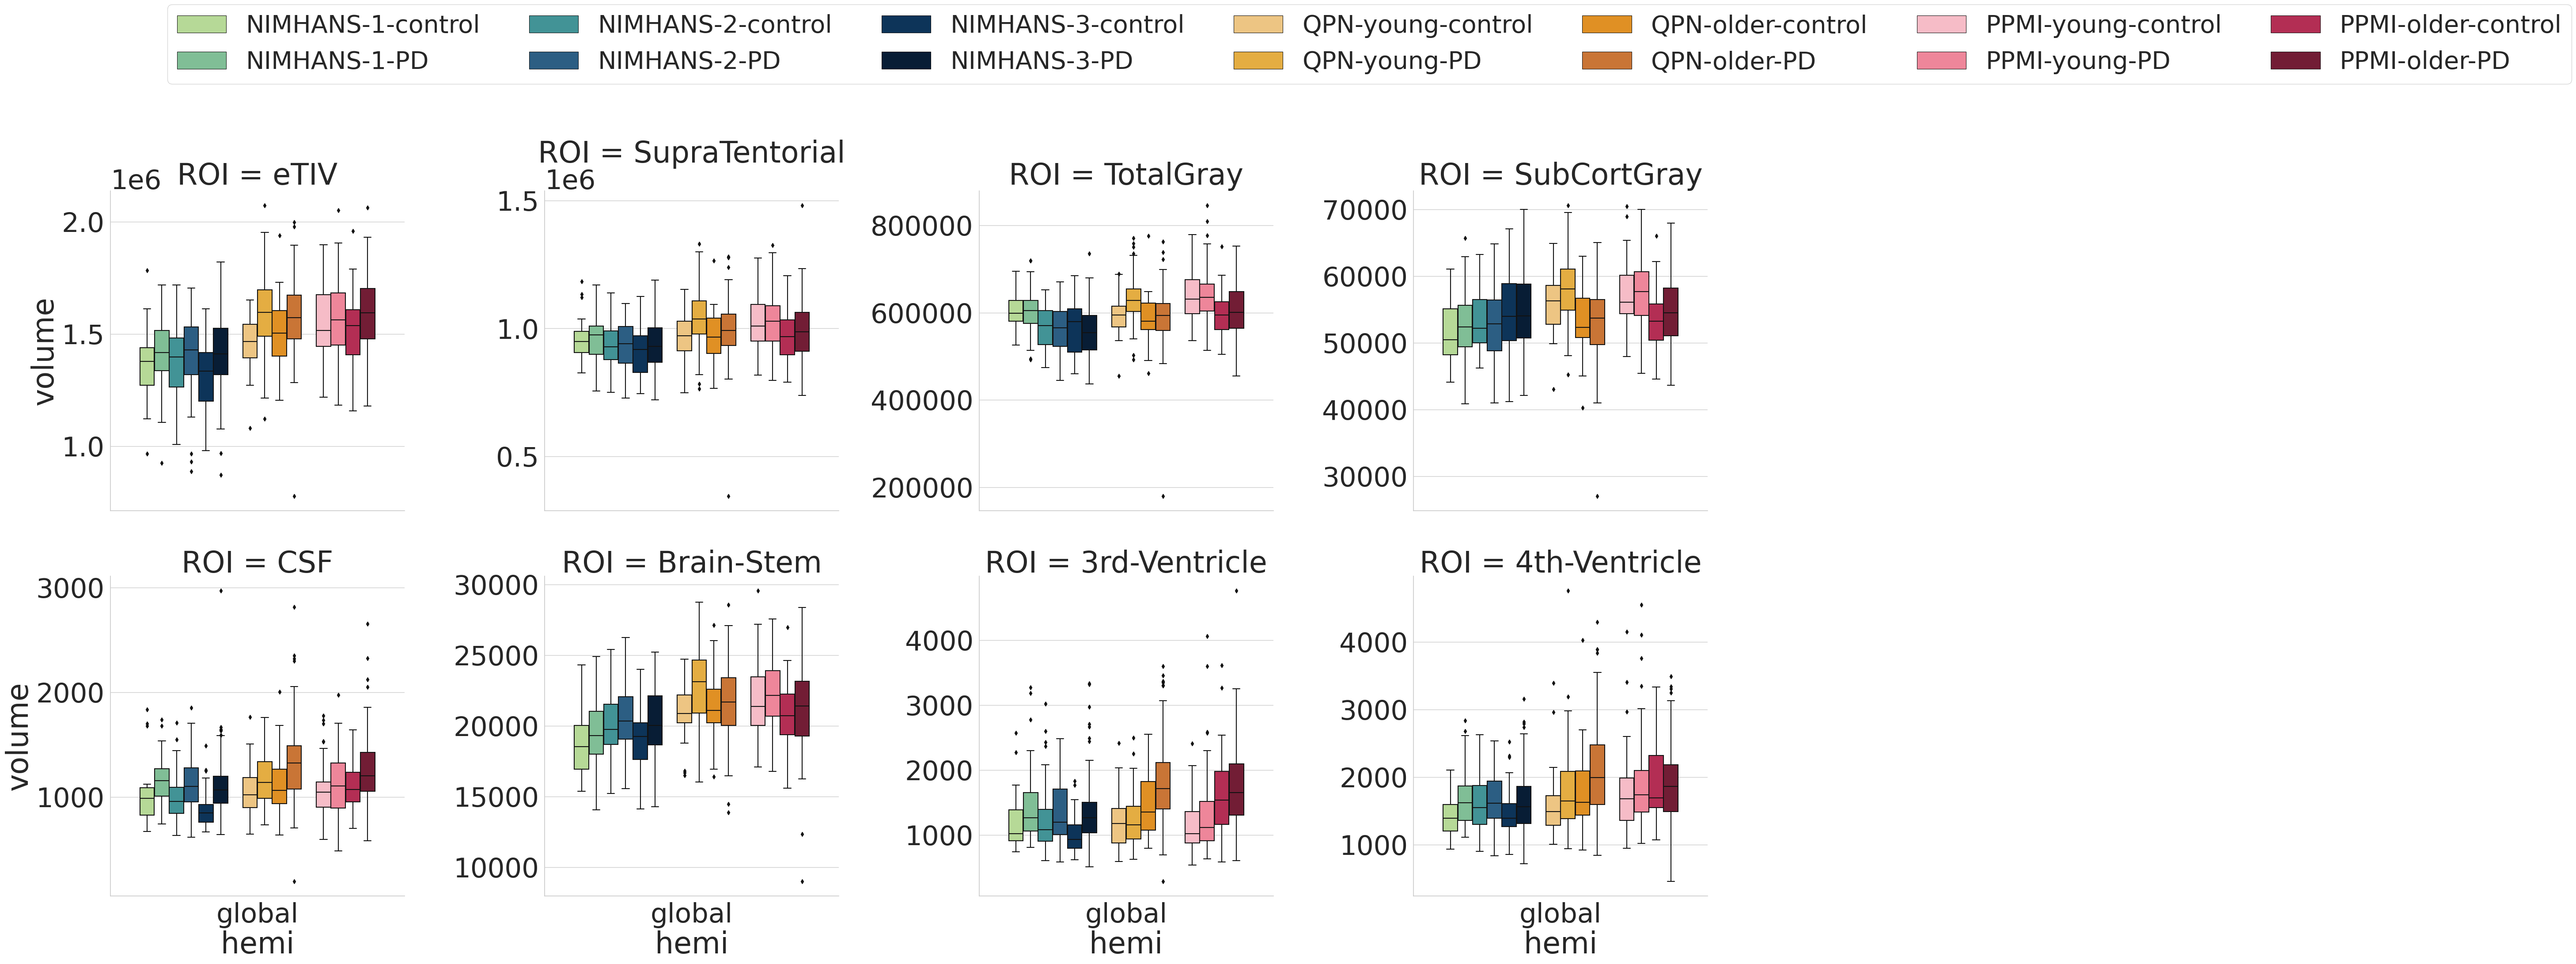

In [14]:
save_fig = False

global_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]

# global_vol_ASEG_df = global_vol_ASEG_df[global_vol_ASEG_df["dataset"].isin(["PPMI", "QPN","NIMHANS_SERB"])]

global_vol_ASEG_df = global_vol_ASEG_df[global_vol_ASEG_df["group"].isin(["control", "PD"])]

global_vol_ASEG_df = global_vol_ASEG_df.rename(columns={"EstimatedTotalIntraCranial":"eTIV"})

global_vol_ASEG_df = global_vol_ASEG_df[demo_cols + ["ds_group"] + global_roi_list].copy()

global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols+["ds_group"],
    var_name="ROI", 
    value_name="volume",
)

global_vol_ASEG_df_melt["ROI"] = global_vol_ASEG_df_melt["ROI"].astype(str)

plot_df = global_vol_ASEG_df_melt.copy()

plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

color_list = [  my_colors.NIM_SERB_CONTROL.value, my_colors.NIM_SERB_PD.value,
                my_colors.NIM_METAL_CONTROL.value, my_colors.NIM_METAL_PD.value,
                my_colors.NIM_YLO_CONTROL.value, my_colors.NIM_YLO_PD.value,
                "white",
                my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
                my_colors.QPN_older_CONTROL.value, my_colors.QPN_older_PD.value,
                "white",
                my_colors.PPMI_CONTROL.value, my_colors.PPMI_PD.value,
                my_colors.PPMI_older_CONTROL.value, my_colors.PPMI_older_PD.value              
              ]

palette = sns.color_palette(palette=color_list)

hue_order = ["NIMHANS-1-control", "NIMHANS-1-PD", "NIMHANS-2-control", "NIMHANS-2-PD", 
             "NIMHANS-3-control", "NIMHANS-3-PD", "",
             "QPN-young-control", "QPN-young-PD", "QPN-older-control", "QPN-older-PD", "",
             "PPMI-young-control",  "PPMI-young-PD","PPMI-older-control",  "PPMI-older-PD"] 

sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI", kind="box", col_wrap=4, 
                    col_order=global_roi_list, 
                    hue_order=hue_order,
                    palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=False)
    
    plt.legend(bbox_to_anchor =(-0.15,2.5), loc='lower center',ncol=7, fontsize=40)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")

### Demographics

In [15]:
demo_df = global_vol_ASEG_df[demo_cols].copy()
demo_df.groupby(["ds","group"]).count()

participant_id  bids_id  age  sex  hemi
ds         group                                           
NIMHANS-1  PD                   64       64   54   55    64
           control              22       22   15   15    22
NIMHANS-2  PD                   66       66   59   59    66
           control              64       64   64   64    64
NIMHANS-3  PD                  198      198  198  198   198
           control              39       39   37   38    39
PPMI-older PD                  124        0  124  124   124
           control              37        0   37   37    37
PPMI-young PD                  105        0  105  105   105
           control              42        0   42   42    42
QPN-older  PD                  131        0  131  128   131
           control              35        0   35   34    35
QPN-young  PD                   68        0   68   66    68
           control              27        0   27   25    27

In [16]:
demo_df.groupby(["ds","group", "sex"])["age"].describe()

count       mean        std    min      25%  \
ds         group   sex                                                   
NIMHANS-1  PD      F         7.0  56.857143   8.071113  44.00  52.5000   
                   M        47.0  55.170213   7.130215  36.00  50.5000   
           control F         2.0  53.000000   4.242641  50.00  51.5000   
                   M        13.0  51.846154   6.361946  41.00  48.0000   
NIMHANS-2  PD      F        13.0  50.384615  11.493030  32.00  44.0000   
                   M        46.0  54.565217   9.653214  24.00  50.0000   
           control F        16.0  48.937500   8.977518  34.00  41.7500   
                   M        48.0  50.375000  10.920652  20.00  44.7500   
NIMHANS-3  PD      Female   56.0  52.535714   9.755119  28.00  45.7500   
                   Male    142.0  54.683099  11.406959  23.00  48.0000   
           control Female   21.0  47.309524  11.100086  25.00  42.0000   
                   Male     16.0  40.000000  10.972693  25.00  30.0000   
PPMI-older PD      F        38.0  69.842105   4.499407  63.00  66.2500   
                   M        86.0  69.372093   4.650228  63.00  65.0000   
           control F        11.0  66.363636   3.354779  63.00  64.0000   
                   M        26.0  70.076923   5.275779  64.00  65.0000   
PPMI-young PD      F        42.0  54.190476   4.809737  39.00  51.0000   
                   M        63.0  54.285714   6.269302  38.00  50.0000   
           control F        16.0  53.250000   5.859465  40.00  52.2500   
                   M        26.0  50.653846   8.948485  31.00  44.2500   
QPN-older  PD      F        41.0  71.336829   5.399339  63.59  66.6600   
                   M        87.0  70.479770   5.564732  63.23  65.8450   
           control F        20.0  69.574500   5.466231  63.39  66.4525   
                   M        14.0  71.179286   3.765318  65.52  68.5150   
QPN-young  PD      F        23.0  54.791304   5.059251  43.30  52.3250   
                   M        43.0  56.122093   4.916127  40.83  53.1500   
           control F        18.0  52.472778   8.189894  38.30  45.5150   
                   M         7.0  53.644286   5.026529  46.46  50.4800   

                              50%      75%    max  
ds         group   sex                             
NIMHANS-1  PD      F       58.000  62.0000  67.00  
                   M       56.000  61.0000  66.00  
           control F       53.000  54.5000  56.00  
                   M       53.000  57.0000  60.00  
NIMHANS-2  PD      F       47.000  59.0000  72.00  
                   M       55.000  61.0000  71.00  
           control F       49.000  56.2500  65.00  
                   M       51.000  58.0000  73.00  
NIMHANS-3  PD      Female  53.500  60.0000  70.00  
                   Male    56.000  63.7500  78.00  
           control Female  49.000  54.0000  65.00  
                   Male    40.500  48.2500  59.00  
PPMI-older PD      F       70.500  73.0000  78.00  
                   M       69.000  72.0000  82.00  
           control F       65.000  69.0000  73.00  
                   M       69.500  72.7500  81.00  
PPMI-young PD      F       55.000  57.0000  62.00  
                   M       56.000  60.0000  62.00  
           control F       54.500  56.5000  60.00  
                   M       52.500  57.7500  62.00  
QPN-older  PD      F       70.880  76.5300  82.22  
                   M       69.480  73.8450  88.34  
           control F       68.130  70.3375  82.84  
                   M       70.975  72.8750  78.97  
QPN-young  PD      F       55.910  57.9700  62.64  
                   M       56.740  60.4850  62.64  
           control F       53.320  60.5325  62.72  
                   M       54.960  56.7900  59.55

### OLS

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [18]:
stat_df = global_vol_ASEG_df.copy()
dataset_list = ["NIMHANS-1","NIMHANS-2"]
hemi = "global"
stat_df = stat_df[(stat_df["ds"].isin(dataset_list)) & (stat_df["hemi"]==hemi)]

brain_var = "eTIV"
demo_vars = ["participant_id","age","sex","group","hemi","ds"]

input_var = demo_vars + [brain_var]

stat_df = stat_df[input_var]
stat_df.head()

,participant_id,age,sex,group,hemi,ds,eTIV
0,SERB088,54.0,M,PD,global,NIMHANS-1,1.426910e+06
1,SERB058,64.0,M,PD,global,NIMHANS-1,1.296458e+06
2,SERB049,62.0,M,PD,global,NIMHANS-1,1.566405e+06
3,SERB084,NaN,NaN,PD,global,NIMHANS-1,1.213594e+06
4,SERB063,56.0,M,PD,global,NIMHANS-1,1.264406e+06


In [19]:
def get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction=False):
    cvar_str = ""
    for cvar in cat_vars:
        cvar_str = "".join([f"{cvar_str} + C({cvar})"])    

    if global_correction:
        formula = f"{dep_var} ~ {ind_var}{cvar_str} + {global_correction}"
    else:
        formula = f"{dep_var} ~ {ind_var}{cvar_str}"
        
    print(f"formula: {formula}")
    res = smf.ols(formula=formula, data=stat_df).fit()
    coef_df = pd.DataFrame(columns=["coef"], data=res.params)
    tval_df = pd.DataFrame(columns=["tvalues"], data=res.tvalues)
    pval_df = pd.DataFrame(columns=["pvalues"], data=res.pvalues)
    res_df = pd.concat([coef_df, tval_df, pval_df], axis=1)
    res_df = res_df.reset_index().rename(columns={"index":"var"})

    return res_df, res, formula

### Replication analysis
- Group differences within each dataset

In [21]:
ind_var = "age"
cat_vars = ["sex", "group"]
dataset_list = ["NIMHANS-1","NIMHANS-2","NIMHANS-","QPN-young","PPMI-young","QPN-older","PPMI-older"]

pval_thresh = 0.05

### Global volumes

In [22]:
brain_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", "CSF"]
hemi = "global"
res_df = pd.DataFrame()
for ds in dataset_list:
    for dep_var in brain_roi_list:
        print(f"ds:{ds}, ind_var:{ind_var}")
        stat_df = global_vol_ASEG_df.copy()
        stat_df = stat_df[(stat_df["ds"]==ds) & (stat_df["hemi"]==hemi)]
        _df, res, formula = get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction=False)
        _df["ROI"] = dep_var
        _df["hemi"] = hemi
        _df["ds"] = ds
        res_df = pd.concat([res_df, _df], axis=0)


res_df[(res_df["var"]=="C(group)[T.control]") & (res_df["pvalues"] < pval_thresh)]

ds:NIMHANS-1, ind_var:age
formula: eTIV ~ age + C(sex) + C(group)
ds:NIMHANS-1, ind_var:age
formula: SupraTentorial ~ age + C(sex) + C(group)
ds:NIMHANS-1, ind_var:age
formula: TotalGray ~ age + C(sex) + C(group)
ds:NIMHANS-1, ind_var:age
formula: SubCortGray ~ age + C(sex) + C(group)
ds:NIMHANS-1, ind_var:age
formula: CSF ~ age + C(sex) + C(group)
ds:NIMHANS-2, ind_var:age
formula: eTIV ~ age + C(sex) + C(group)
ds:NIMHANS-2, ind_var:age
formula: SupraTentorial ~ age + C(sex) + C(group)
ds:NIMHANS-2, ind_var:age
formula: TotalGray ~ age + C(sex) + C(group)
ds:NIMHANS-2, ind_var:age
formula: SubCortGray ~ age + C(sex) + C(group)
ds:NIMHANS-2, ind_var:age
formula: CSF ~ age + C(sex) + C(group)
ds:NIMHANS-, ind_var:age
formula: eTIV ~ age + C(sex) + C(group)


ValueError: negative dimensions are not allowed

### Subcortical volumes

In [23]:
brain_roi_list = ['Pallidum', 'ThalamusProper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'AccumbensArea']
hemi_list = ["lh", "rh"]
global_correction = "eTIV"
# rename columns with "-" to remove error in statsmodels
hemi_ASEG_df = hemi_ASEG_df.rename(columns={"Thalamus-Proper":"ThalamusProper", 'Accumbens-area':'AccumbensArea'})

res_dict = {}
res_df = pd.DataFrame()
for ds in dataset_list:
    for dep_var in brain_roi_list:
        for hemi in hemi_list:
            # print(f"ds:{ds}, ind_var:{ind_var}")
            stat_df = hemi_ASEG_df.copy()
            stat_df = stat_df[(stat_df["ds"]==ds) & (stat_df["hemi"]==hemi)].copy()

            if global_correction:
                stat_df = pd.merge(stat_df, global_vol_ASEG_df[["participant_id","eTIV"]], on="participant_id", how="left")
                _df, res, formula = get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction)
            else:
                _df, res, formula = get_stats(stat_df, ind_var, dep_var, cat_vars)

            _df["ROI"] = dep_var
            _df["hemi"] = hemi
            _df["dataset"] = ds
            res_df = pd.concat([res_df, _df], axis=0)
            res_dict[(dep_var, hemi, ds)] = res


res_df[(res_df["var"]=="C(group)[T.control]") & (res_df["pvalues"] < pval_thresh)]

formula: Pallidum ~ age + C(sex) + C(group) + eTIV
formula: Pallidum ~ age + C(sex) + C(group) + eTIV
formula: ThalamusProper ~ age + C(sex) + C(group) + eTIV
formula: ThalamusProper ~ age + C(sex) + C(group) + eTIV
formula: Putamen ~ age + C(sex) + C(group) + eTIV
formula: Putamen ~ age + C(sex) + C(group) + eTIV
formula: Amygdala ~ age + C(sex) + C(group) + eTIV
formula: Amygdala ~ age + C(sex) + C(group) + eTIV
formula: Caudate ~ age + C(sex) + C(group) + eTIV
formula: Caudate ~ age + C(sex) + C(group) + eTIV
formula: Hippocampus ~ age + C(sex) + C(group) + eTIV
formula: Hippocampus ~ age + C(sex) + C(group) + eTIV
formula: AccumbensArea ~ age + C(sex) + C(group) + eTIV
formula: AccumbensArea ~ age + C(sex) + C(group) + eTIV
formula: Pallidum ~ age + C(sex) + C(group) + eTIV
formula: Pallidum ~ age + C(sex) + C(group) + eTIV
formula: ThalamusProper ~ age + C(sex) + C(group) + eTIV
formula: ThalamusProper ~ age + C(sex) + C(group) + eTIV
formula: Putamen ~ age + C(sex) + C(group) + e

ValueError: negative dimensions are not allowed

In [46]:
Objectives:
Deploy informatics: ... tasks in NorthAmerican and Indian studies. 

Methods:
... following nipoppy protocols

MRI processing - combine FS and DKT


Results
We harmonized and processed >1000 participants using Nipoppy and Neurobagel. Fig. 2 shows distributions for several IDPs for CTh, global and regional volumetric measures.
NIMHANS-1 shows scanner related bias with higher CTh values on average.
PD-vs-control comparisons show significant increase in CSF volume in PPMI-older (p=0.001) and NIMHANS (p=0.003) cohorts; increase in L-Thalamic volume in QPN-young (p=0.03) and PPMI-young (p=0.03); reduction in bilateral Putamen in NIMHANS-2 (p=0.02); reduction in CTh values in several disparate ROIs the QPN-older and PPMI-older cohorts including R-entorhinal (p=0.01), R-inferiortemporal (p=0.03), R-medialorbitofrontal (p=0.005), L-rostralanteriorcingulate (p=0.03), L-rostralmiddlefrontal (p=0.04) 
Thalamus, Putamen, Amygdala, Hippocampus, Accumbens, & several cerebellar lobules show stronger age-related effect compared to group differences.


Discussion
- Scanner, protocol, Software-version 
- Age-at-onset seems to be earlier in Indian cohorts. 
- Cortical thickness is affected more in older PD patients 



SyntaxError: invalid syntax (365156329.py, line 3)

In [ ]:
2	C(group)[T.control]	-0.133383	-2.094447	0.040123	posteriorcingulate	rh	NIMHANS-1
2	C(group)[T.control]	0.067736	2.717475	0.007561	parstriangularis	lh	NIMHANS-2
2	C(group)[T.control]	-0.081230	-2.215796	0.032049	caudalmiddlefrontal	rh	QPN-young
2	C(group)[T.control]	-0.082680	-2.198430	0.033349	parsopercularis	lh	QPN-young
2	C(group)[T.control]	-0.159965	-2.272166	0.028135	transversetemporal	lh	QPN-young
2	C(group)[T.control]	0.182673	2.663298	0.009396	entorhinal	rh	QPN-older
2	C(group)[T.control]	0.068783	2.189899	0.031520	inferiortemporal	rh	QPN-older
2	C(group)[T.control]	0.060743	2.010296	0.047857	lateraloccipital	rh	QPN-older
2	C(group)[T.control]	0.099022	2.876048	0.005190	medialorbitofrontal	rh	QPN-older
2	C(group)[T.control]	0.086935	2.129477	0.036369	rostralanteriorcingulate	lh	QPN-older
2	C(group)[T.control]	0.047737	2.082312	0.040592	rostralmiddlefrontal	lh	QPN-older

### Compare older and younger groups

In [32]:
global_correction = "eTIV"
ind_var = "age"
cat_vars = ["sex", "ds", "group"]

res_df = pd.DataFrame()

for dep_var in brain_roi_list:
    for hemi in hemi_list:
        # print(f"ds:{ds}, ind_var:{ind_var}")
        stat_df = hemi_ASEG_df.copy()
        stat_df = stat_df[stat_df["ds"].isin(["PPMI-young","PPMI-older"])].copy()
        stat_df = stat_df[(stat_df["hemi"]==hemi)].copy()

        if global_correction:
            stat_df = pd.merge(stat_df, global_vol_ASEG_df[["participant_id","eTIV"]], on="participant_id", how="left")
            _df, _, formula = get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction)
        else:
            _df, _, formula = get_stats(stat_df, ind_var, dep_var, cat_vars)

        _df["ROI"] = dep_var
        _df["hemi"] = hemi
        # _df["dataset"] = ds
        res_df = pd.concat([res_df, _df], axis=0)

formula: Pallidum ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: Pallidum ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: ThalamusProper ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: ThalamusProper ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: Putamen ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: Putamen ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: Amygdala ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: Amygdala ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: Caudate ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: Caudate ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: Hippocampus ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: Hippocampus ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: AccumbensArea ~ age + C(sex) + C(ds) + C(group) + eTIV
formula: AccumbensArea ~ age + C(sex) + C(ds) + C(group) + eTIV


In [33]:
res_df[(res_df["pvalues"] < pval_thresh)]

,var,coef,tvalues,pvalues,ROI,hemi
0,Intercept,1236.739225,5.847504,1.306337e-08,Pallidum,lh
4,age,-7.744053,-3.398381,7.698050e-04,Pallidum,lh
5,eTIV,0.000827,8.299370,3.642049e-15,Pallidum,lh
0,Intercept,1133.679144,5.931948,8.239138e-09,Pallidum,rh
4,age,-8.040097,-3.894832,1.211886e-04,Pallidum,rh
5,eTIV,0.000847,9.390185,1.563335e-18,Pallidum,rh
0,Intercept,5039.256110,10.100047,7.904099e-21,ThalamusProper,lh
4,age,-44.404916,-8.260366,4.753870e-15,ThalamusProper,lh
5,eTIV,0.003094,13.160723,1.619729e-31,ThalamusProper,lh
0,Intercept,4201.971595,8.606518,4.304345e-16,ThalamusProper,rh


### CTh

In [39]:
brain_roi_list = CT_DKT_df[CT_DKT_df.columns[~CT_DKT_df.columns.isin(demo_cols + ["ds_group","ds_hemi"])]].columns
print(f"n_brain_rois: {len(brain_roi_list)}")
hemi_list = ["lh", "rh"]

res_df = pd.DataFrame()
for ds in dataset_list:
    for dep_var in brain_roi_list:
        for hemi in hemi_list:
            # print(f"ds:{ds}, ind_var:{ind_var}")
            stat_df = CT_DKT_df.copy()
            stat_df = stat_df[(stat_df["ds"]==ds) & (stat_df["hemi"]==hemi)]
            _df, _, formula = get_stats(stat_df, ind_var, dep_var, cat_vars)
            _df["ROI"] = dep_var
            _df["hemi"] = hemi
            _df["ds"] = ds
            res_df = pd.concat([res_df, _df], axis=0)


res_df[(res_df["var"]=="C(group)[T.control]") & (res_df["pvalues"] < pval_thresh)]

n_brain_rois: 31
formula: caudalanteriorcingulate ~ age + C(sex) + C(group)
formula: caudalanteriorcingulate ~ age + C(sex) + C(group)
formula: caudalmiddlefrontal ~ age + C(sex) + C(group)
formula: caudalmiddlefrontal ~ age + C(sex) + C(group)
formula: cuneus ~ age + C(sex) + C(group)
formula: cuneus ~ age + C(sex) + C(group)
formula: entorhinal ~ age + C(sex) + C(group)
formula: entorhinal ~ age + C(sex) + C(group)
formula: fusiform ~ age + C(sex) + C(group)
formula: fusiform ~ age + C(sex) + C(group)
formula: inferiorparietal ~ age + C(sex) + C(group)
formula: inferiorparietal ~ age + C(sex) + C(group)
formula: inferiortemporal ~ age + C(sex) + C(group)
formula: inferiortemporal ~ age + C(sex) + C(group)
formula: insula ~ age + C(sex) + C(group)
formula: insula ~ age + C(sex) + C(group)
formula: isthmuscingulate ~ age + C(sex) + C(group)
formula: isthmuscingulate ~ age + C(sex) + C(group)
formula: lateraloccipital ~ age + C(sex) + C(group)
formula: lateraloccipital ~ age + C(sex) + 

,var,coef,tvalues,pvalues,ROI,hemi,ds
2,C(group)[T.control],-0.133383,-2.094447,0.040123,posteriorcingulate,rh,NIMHANS-1
2,C(group)[T.control],0.067736,2.717475,0.007561,parstriangularis,lh,NIMHANS-2
2,C(group)[T.control],-0.081230,-2.215796,0.032049,caudalmiddlefrontal,rh,QPN-young
2,C(group)[T.control],-0.082680,-2.198430,0.033349,parsopercularis,lh,QPN-young
2,C(group)[T.control],-0.159965,-2.272166,0.028135,transversetemporal,lh,QPN-young
2,C(group)[T.control],0.182673,2.663298,0.009396,entorhinal,rh,QPN-older
2,C(group)[T.control],0.068783,2.189899,0.031520,inferiortemporal,rh,QPN-older
2,C(group)[T.control],0.060743,2.010296,0.047857,lateraloccipital,rh,QPN-older
2,C(group)[T.control],0.099022,2.876048,0.005190,medialorbitofrontal,rh,QPN-older
2,C(group)[T.control],0.086935,2.129477,0.036369,rostralanteriorcingulate,lh,QPN-older


### Cross-cohort comparisons

In [36]:
brain_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", "CSF"]
ind_var = "age"
cat_vars = ["sex", "ds_group"]
pval_thresh = 0.05

group_list = ["control","PD"]
hemi = "global"
res_df = pd.DataFrame()
for grp in group_list:
    for dep_var in brain_roi_list:
        # print(f"ds:{ds}, ind_var:{ind_var}")
        stat_df = global_vol_ASEG_df.copy()
        stat_df = stat_df[(stat_df["group"]==grp) & (stat_df["hemi"]==hemi)]
        _df, _, formula = get_stats(stat_df, ind_var, dep_var, cat_vars)
        _df["ROI"] = dep_var
        _df["hemi"] = hemi
        _df["group"] = grp
        res_df = pd.concat([res_df, _df], axis=0)


res_df[(~res_df["var"].isin(["Intercept","C(sex)[T.M]","age"])) & (res_df["pvalues"] < pval_thresh)]

formula: eTIV ~ age + C(sex) + C(ds_group)
formula: SupraTentorial ~ age + C(sex) + C(ds_group)


formula: TotalGray ~ age + C(sex) + C(ds_group)
formula: SubCortGray ~ age + C(sex) + C(ds_group)
formula: CSF ~ age + C(sex) + C(ds_group)
formula: eTIV ~ age + C(sex) + C(ds_group)
formula: SupraTentorial ~ age + C(sex) + C(ds_group)
formula: TotalGray ~ age + C(sex) + C(ds_group)
formula: SubCortGray ~ age + C(sex) + C(ds_group)
formula: CSF ~ age + C(sex) + C(ds_group)


,var,coef,tvalues,pvalues,ROI,hemi,group
3,C(ds_group)[T.PPMI-older-control],143468.775682,3.291355,1.192998e-03,eTIV,global,control
4,C(ds_group)[T.PPMI-young-control],217318.535268,5.666676,5.467275e-08,eTIV,global,control
5,C(ds_group)[T.QPN-older-control],163145.676866,3.369747,9.147508e-04,eTIV,global,control
6,C(ds_group)[T.QPN-young-control],204205.302583,4.173749,4.596517e-05,eTIV,global,control
4,C(ds_group)[T.PPMI-young-control],77831.391915,3.203691,1.596515e-03,SupraTentorial,global,control
6,C(ds_group)[T.QPN-young-control],65783.451421,2.122463,3.512198e-02,SupraTentorial,global,control
2,C(ds_group)[T.NIMHANS-2-control],-37252.539224,-3.023130,2.854800e-03,TotalGray,global,control
4,C(ds_group)[T.PPMI-young-control],33705.441944,2.596574,1.016843e-02,TotalGray,global,control
3,C(ds_group)[T.PPMI-older-control],5036.882335,3.619566,3.802884e-04,SubCortGray,global,control
4,C(ds_group)[T.PPMI-young-control],6488.555502,5.299769,3.259795e-07,SubCortGray,global,control


In [40]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ThalamusProper   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     25.66
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           2.61e-15
Time:                        13:15:02   Log-Likelihood:                -929.55
No. Observations:                 123   AIC:                             1869.
Df Residuals:                     118   BIC:                             1883.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            4420.5298    472.369      9.358      0.000    3485.112    5355.948
C(sex)[T.M]           -58.6098    126.904     -0.462      0.645    -309.913     192.694
C(group)[T.control]   207.2230     86.730      2.389      0.018      35.474     378.972
age                   -22.4070      4.210     -5.323      0.000     -30.744     -14.070
eTIV                    0.0023      0.000      6.818      0.000       0.002       0.003
==============================================================================
Omnibus:                        1.570   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.456   Jarque-Bera (JB):                1.283
Skew:                           0.248   Prob(JB):                        0.526
Kurtosis:                       3.068   Cond. No.                     1.56e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""